In [71]:
# importing modules to perform linear regession model (supervised learning model)
import pandas as pd
import numpy as np
import datetime
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns
# import scipy.stats
# Import the estimator class - Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Importing MinMaxScaler from scikit-learn to transmute the observed data 
from sklearn.preprocessing import MinMaxScaler

# pip install finpie==0.1
from finpie.economic_data import oecd_data

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Reading in the GDP data from FRED (St.Louis FED)
data_source = 'fred'
# Creating a range of dates - start and end
start = datetime.datetime (1960, 1, 1) 
end = datetime.datetime (2030, 12, 1)

In [3]:
#  U.S. GDP Seasonally Adjusted
gdp = pdr.DataReader('GDPC1', data_source, start, end)
# Renaming index
gdp.index.name = "Date"
# Renaming column
gdp.columns = ['gdp']
# Adding a YoY % change column
gdp['gdp_%yoy'] = gdp['gdp'].pct_change(4) * 100
# Dropping the null(NaN) values
gdp.dropna(inplace=True)
# Rounding to 2 decimal places
gdp = gdp.round(2)

# Reading in the OECD CLI data (Monthly)- amplitude adjusted 
oecd = oecd_data.OecdData(country_code = 'USA', freq = 'M')
cli = pd.DataFrame(oecd.cli(subject = 'amplitude'))

# Dropping columns and renaming the index and the column `cli`
cli.drop(['SUBJECT', 'Subject', 
          'Country', 'FREQUENCY', 
          'TIME', 'Unit Code', 
          'PowerCode Code'], axis=1, inplace=True)

cli.index.name = "Date"
cli.columns = ['cli']

# Changing and checking that the `cli.index` was changed to a datetime format
cli.index = pd.to_datetime(cli.index)

# Will use this later for analyzing monthly data - `cli_monthly` DataFrame
cli_monthly = cli.copy()

print(type(cli.index))
cli_monthly.tail()

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


,cli
Date,
2022-02-01,99.96445
2022-03-01,99.82504
2022-04-01,99.67831
2022-05-01,99.52129
2022-06-01,99.36380


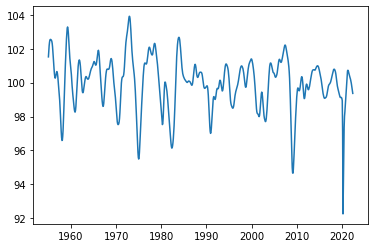

,gdp_%yoy,cli
Date,,
2021-04-01,12.23,100.69020
2021-07-01,4.95,100.61900
2021-10-01,5.53,100.34650
2022-01-01,3.53,100.08820
2022-04-01,1.62,99.67831


In [4]:
# cli.to_csv("../../assets/datasets/cli.csv")

# Changing and checking that the `gdp.index` was changed to a datetime format
gdp.index = pd.to_datetime(gdp.index)

# A quick view at the GDP YoY % change chart
# plt.plot(gdp.index, gdp['gdp_%yoy'])
# plt.show()

# A quick view at the CLI chart
plt.plot(cli.index, cli['cli'])
plt.show()

# Merging GDP and CLI data 
# Because GDP data is quartely the CLI data has changed from monthly to quarterly data after merging both dataframes
df = pd.merge(gdp, cli, left_index=True, right_index=True)
gdp_cli = df[['gdp_%yoy', 'cli']].copy()
cli.tail()

# print(type(gdp.index))
gdp_cli.tail()

In [5]:
# Initializing MinMaxScaler using a range of -1 to 1 because data needs to oscilate around 0
scaler = MinMaxScaler(feature_range=(-1,1))
# Applying scaler to data
scaled_df = scaler.fit_transform(gdp_cli)

# Converting the array back to a DataFrame and using the same column headers and index header
normalized_df = pd.DataFrame(scaled_df, index=gdp_cli.index, columns = gdp_cli.columns)
# Rounding the DataFrame to 3 decimal places
normalized_df = normalized_df.round(3)

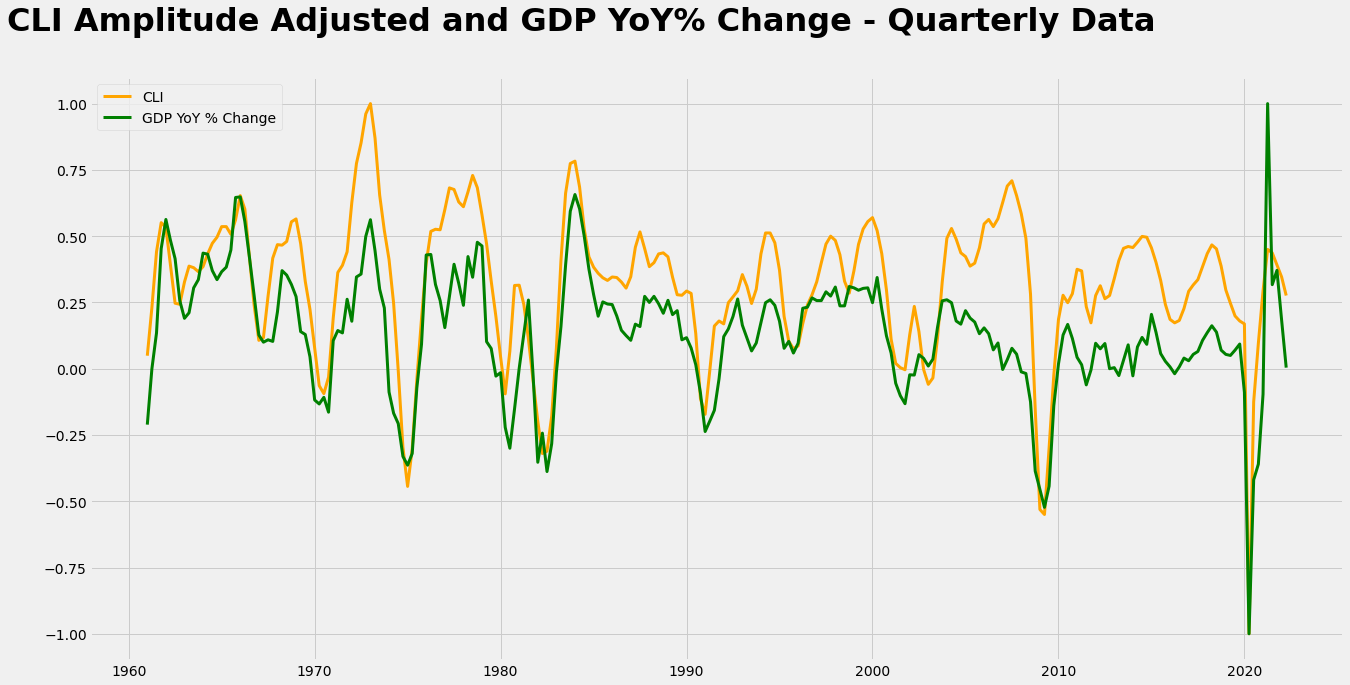

In [6]:
"""Plotting line graphs """
# Plot style
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(20,10)) # chart size 2:1

# Sets Title of Plot
ax.set_title("CLI Amplitude Adjusted and GDP YoY% Change - Quarterly Data", fontsize=32, fontweight='bold', x=.392, y=1.07)

# Lineplot of CLI
plt.plot(normalized_df.index, normalized_df.cli, color='orange', linewidth=3, label="CLI")
# Lineplot of GDP YoY % Change
plt.plot(normalized_df.index, normalized_df['gdp_%yoy'], color='green', linewidth=3, label = "GDP YoY % Change")

# Adds a legened
plt.legend(loc="upper left")
# Saving image as a .png file
# plt.savefig('../../assets/datasets/GDP_CLI_lineplot.png', transparent=False, dpi=150)

plt.show()

In [7]:
gdp_cli.tail(12)

,gdp_%yoy,cli
Date,,
2019-07-01,2.32,99.23283
2019-10-01,2.57,99.12160
2020-01-01,0.63,99.05475
2020-04-01,-9.08,92.25338
2020-07-01,-2.89,97.34548
2020-10-01,-2.26,98.63333
2021-01-01,0.55,99.78373
2021-04-01,12.23,100.69020
2021-07-01,4.95,100.61900


In [8]:
gdp_cli.describe()

,gdp_%yoy,cli
count,246.000000,246.000000
mean,2.995163,99.952150
std,2.469070,1.523295
min,-9.080000,92.253380
25%,1.747500,99.221730
50%,3.010000,100.117900
75%,4.365000,100.844650
max,12.230000,103.893800


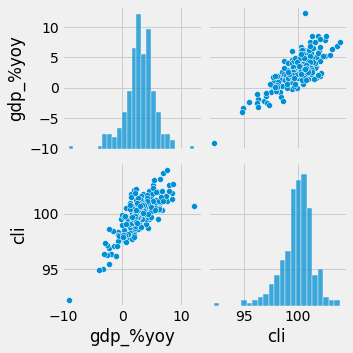

In [9]:
sns.pairplot(gdp_cli)

<AxesSubplot:xlabel='gdp_%yoy', ylabel='Density'>

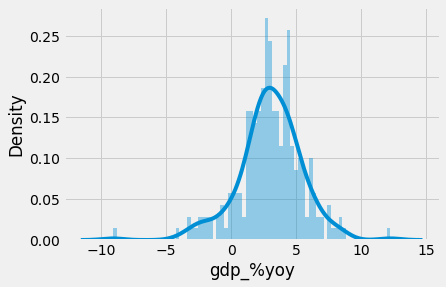

In [10]:
sns.distplot(gdp_cli['gdp_%yoy'], bins=75)

<AxesSubplot:>

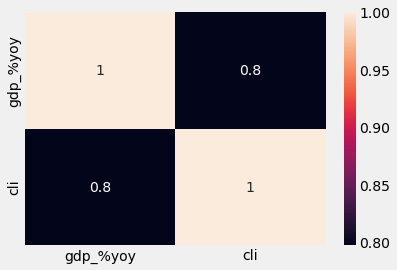

In [11]:
sns.heatmap(gdp_cli.corr(), annot=True)

### LInear Regression Model

In [12]:
df = gdp_cli.copy()
df.columns

Index(['gdp_%yoy', 'cli'], dtype='object')

In [13]:
X = df[['cli']] # training data
y = df['gdp_%yoy'] # target 

In [48]:
# train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.60)

In [49]:
lm = LinearRegression()

In [50]:
lm.fit(X_train, y_train)

LinearRegression()

In [51]:
print(lm.intercept_)

-100.60427399993735


In [52]:
lm.coef_

array([1.03747467])

In [53]:
X.columns

Index(['cli'], dtype='object')

In [54]:
coeff_df = pd.DataFrame(lm.coef_, X.columns, columns = ['Coeff'])

In [55]:
coeff_df

,Coeff
cli,1.037475


In [56]:
predictions = lm.predict(X_test)

In [73]:
predictions

array([ 4.20784992,  2.2866232 ,  0.22809707,  3.48421134,  3.22017403,
        5.87081808,  2.73960539,  4.1144772 ,  2.16561215,  0.57315078,
        4.78198841,  3.02413282,  3.23469868,  4.47354719,  3.90438858,
        4.53932308,  6.94709431,  1.98744663,  4.94570191,  3.37226782,
        3.042216  ,  1.16992696,  4.49191049,  0.93527094,  2.18719163,
        3.66265698,  2.93530424,  1.41441824,  3.15336067,  3.90075742,
        5.08710971,  3.17525138,  5.81759563,  3.22505017,  3.50247089,
        3.13403251,  0.06551442,  3.11190318,  1.93885131,  4.26283608,
        2.61176776,  2.79907344, -1.53557875,  0.99269516,  3.98168045,
        2.83925483,  2.8622764 , -0.68275382,  3.69253625,  2.1144854 ,
        2.61374934,  4.64587173,  2.94066798,  3.78539024,  2.82688814,
        3.38461377, -2.17368792,  0.86750309,  3.78165533,  2.81825635,
        5.17301261,  4.0121822 ,  0.76037346,  2.60951644,  0.38919614,
        2.23204166,  4.32280212,  3.91279213,  2.86381186,  3.11

In [58]:
y_test

Date
1965-07-01    6.35
1975-10-01    2.55
2008-10-01   -2.54
2005-04-01    3.61
1986-04-01    3.70
              ... 
1969-01-01    4.47
1982-07-01   -2.56
2013-04-01    1.30
1963-10-01    5.16
2006-04-01    2.98
Name: gdp_%yoy, Length: 148, dtype: float64

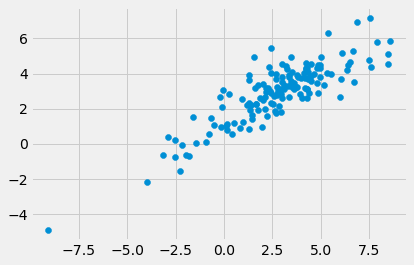

In [59]:
plt.scatter(y_test, predictions)

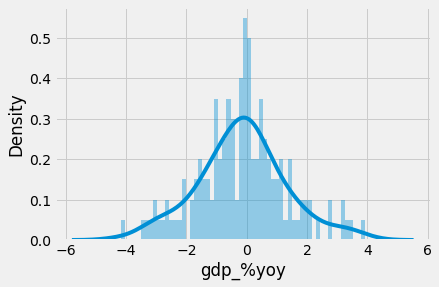

In [66]:
sns.distplot((y_test - predictions), bins=60);

In [68]:
# Mean absolute Error(MAE)
metrics.mean_absolute_error(y_test, predictions)

1.1028889553429886

In [69]:
# Mean squared error (MSE)
metrics.mean_squared_error(y_test, predictions)

2.1474046822367834

In [70]:
# Root Mean Squared Error (RMSE)
np.sqrt(metrics.mean_squared_error(y_test, predictions))

1.4654025666132782

### NON Time series - Linear Regression Model

In [77]:
customers = pd.read_csv("Ecommerce Customers")
customers.head()

,Email,Address,Avatar,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
0,mstephenson@fernandez.com,"835 Frank Tunnel\nWrightmouth, MI 82180-9605",Violet,34.497268,12.655651,39.577668,4.082621,587.951054
1,hduke@hotmail.com,"4547 Archer Common\nDiazchester, CA 06566-8576",DarkGreen,31.926272,11.109461,37.268959,2.664034,392.204933
2,pallen@yahoo.com,"24645 Valerie Unions Suite 582\nCobbborough, D...",Bisque,33.000915,11.330278,37.110597,4.104543,487.547505
3,riverarebecca@gmail.com,"1414 David Throughway\nPort Jason, OH 22070-1220",SaddleBrown,34.305557,13.717514,36.721283,3.120179,581.852344
4,mstephens@davidson-herman.com,"14023 Rodriguez Passage\nPort Jacobville, PR 3...",MediumAquaMarine,33.330673,12.795189,37.536653,4.446308,599.406092


In [78]:
customers.columns

Index(['Email', 'Address', 'Avatar', 'Avg. Session Length', 'Time on App',
       'Time on Website', 'Length of Membership', 'Yearly Amount Spent'],
      dtype='object')

In [79]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Email                 500 non-null    object 
 1   Address               500 non-null    object 
 2   Avatar                500 non-null    object 
 3   Avg. Session Length   500 non-null    float64
 4   Time on App           500 non-null    float64
 5   Time on Website       500 non-null    float64
 6   Length of Membership  500 non-null    float64
 7   Yearly Amount Spent   500 non-null    float64
dtypes: float64(5), object(3)
memory usage: 31.4+ KB


In [82]:
customers.describe()

,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,33.053194,12.052488,37.060445,3.533462,499.314038
std,0.992563,0.994216,1.010489,0.999278,79.314782
min,29.532429,8.508152,33.913847,0.269901,256.670582
25%,32.341822,11.388153,36.349257,2.930450,445.038277
50%,33.082008,11.983231,37.069367,3.533975,498.887875
75%,33.711985,12.753850,37.716432,4.126502,549.313828
max,36.139662,15.126994,40.005182,6.922689,765.518462


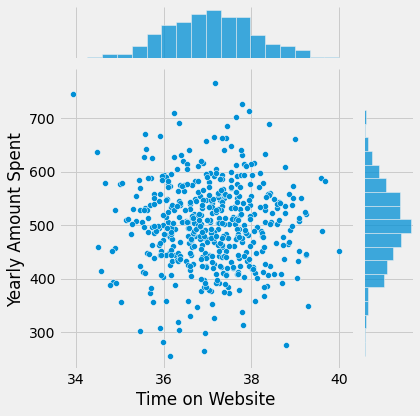

In [128]:
sns.jointplot(data=customers,x='Time on Website', y='Yearly Amount Spent')

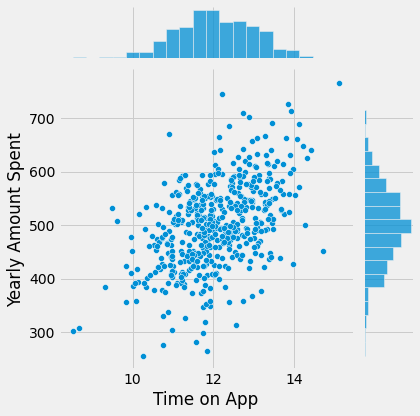

In [129]:
sns.jointplot(data=customers,x='Time on App', y='Yearly Amount Spent')

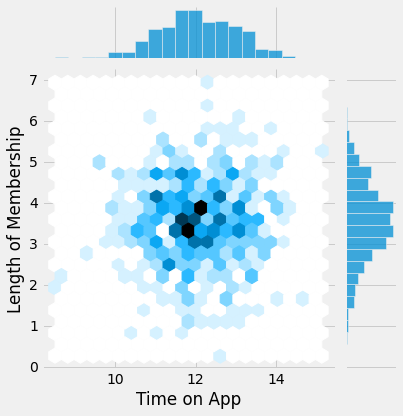

In [132]:
sns.jointplot(data=customers,kind='hex',x='Time on App', y='Length of Membership')

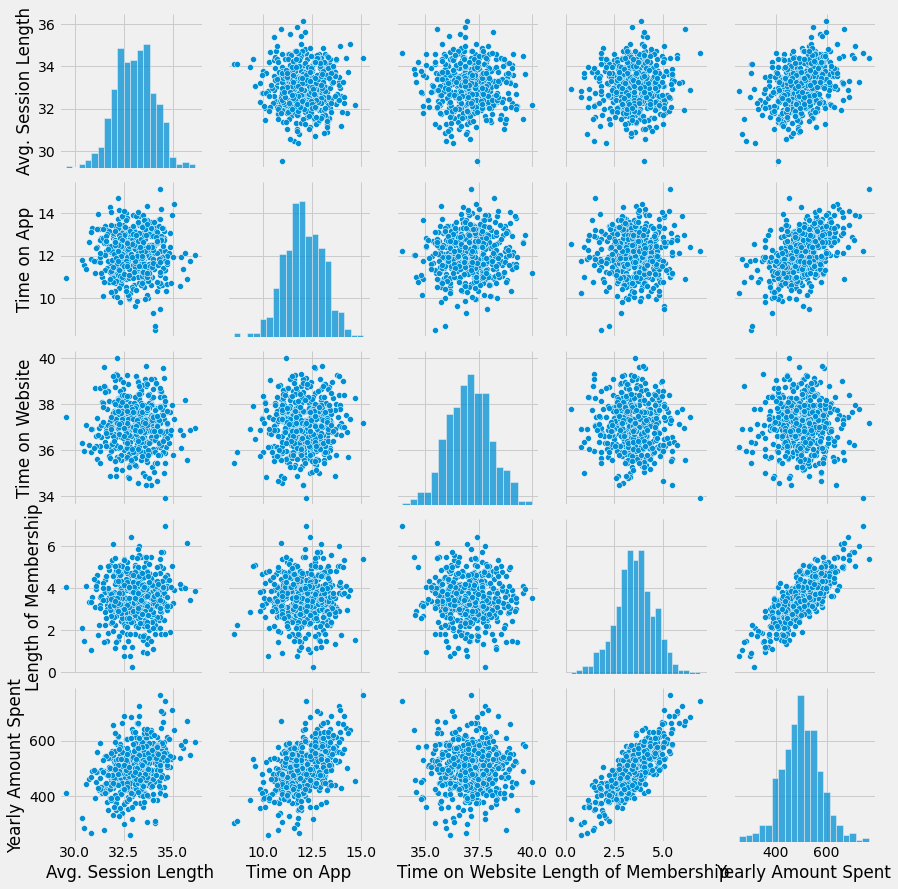

In [84]:
sns.pairplot(customers)

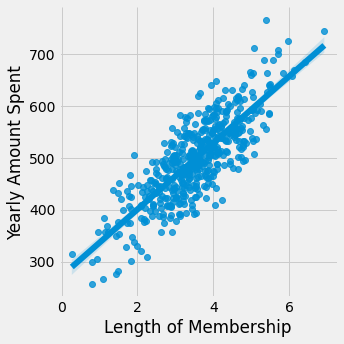

In [134]:
sns.lmplot(x='Length of Membership', y='Yearly Amount Spent', data=customers)

In [139]:
# Setting train features and target feature
X = customers[['Avg. Session Length', 'Time on App',
               'Time on Website', 'Length of Membership']] # training features
y = customers['Yearly Amount Spent'] # target feature

# train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=101)

In [140]:
print(customers.shape[0] - (X_train.shape[0] + X_test.shape[0]))
print(customers.shape[0] - (y_train.shape[0] + y_test.shape[0]))

0
0


In [141]:
print(X.shape[0])
print(y.shape[0])

500
500


In [142]:
# instantiating Linear Model
lm = LinearRegression()

In [143]:
# Fitting Linear regression Model
lm.fit(X_train, y_train)

LinearRegression()

In [144]:
coeff_df = pd.DataFrame(lm.coef_, X.columns, columns = ['Coeff'])

In [145]:
coeff_df

,Coeff
Avg. Session Length,25.981550
Time on App,38.590159
Time on Website,0.190405
Length of Membership,61.279097


In [150]:
predictions = lm.predict(X_test)

Text(0, 0.5, 'Predicted Values')

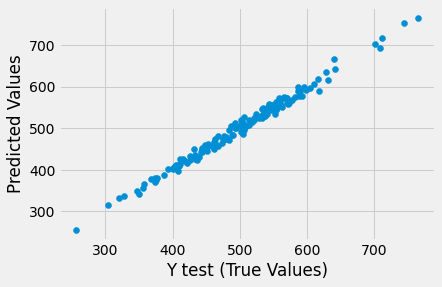

In [151]:
plt.scatter(y_test, predictions)
plt.xlabel('Y test (True Values)')
plt.ylabel('Predicted Values')

In [153]:
from sklearn import metrics

In [157]:
print('MAE ', metrics.mean_absolute_error(y_test, predictions))
print('MSE ', metrics.mean_squared_error(y_test, predictions))
print('RMSE ', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE  7.228148653430826
MSE  79.81305165097427
RMSE  8.933815066978624


In [158]:
# R squared value - how much variance the model explains
print('R squared ', metrics.explained_variance_score(y_test, predictions))

R squared  0.9890771231889606


### Residuals

<AxesSubplot:xlabel='Yearly Amount Spent', ylabel='Density'>

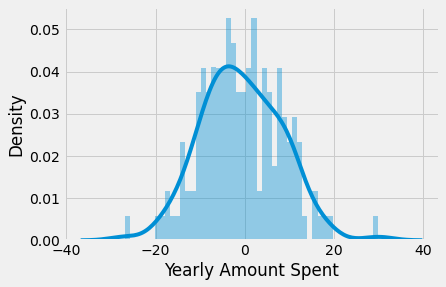

In [159]:
sns.distplot((y_test - predictions), bins=50)

### DataFrame of Coefficients

In [164]:
cdf = pd.DataFrame(lm.coef_, X.columns, columns=['Coeff'])
cdf
# for every 1 unit increase in each variable in the dataframe the Coefficient is
# the increase in dollars

# Therefore, focus on the Time on App to increase dollars

# Determine what the cost of the decisions would be (App of website improvements)

,Coeff
Avg. Session Length,25.981550
Time on App,38.590159
Time on Website,0.190405
Length of Membership,61.279097


In [152]:
import scipy.stats

correlation, pvalue = scipy.stats.pearsonr(customers['Time on App'], customers['Yearly Amount Spent'])
print("Correlation: ", correlation)
print("Pvalue: ", pvalue)

Correlation:  0.4993277700534505
Pvalue:  6.905842369970937e-33
